In [ ]:
# default_exp core

## Core

> API details.

In [ ]:
#hide
from fastcore.test import *
from nbdev.showdoc import *

## Imports

In [ ]:
#hide
#export
import math
from itertools import cycle

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, List, Dict, Any, Union, Optional, Callable

import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad, make_jaxpr

import flax
import flax.linen as nn
import flax.training.train_state as train_state

import optax
from optax import sgd, softmax_cross_entropy

In [ ]:
%matplotlib inline

In [ ]:
#export
def transform(img):
    return np.array(img, dtype=np.float32).reshape(28, 28, 1) / 255.0

def dataset(train=True):
    return datasets.FashionMNIST(root='~/.data', train=train, download=True, transform=transform)

def collate_fn(batch):
    return list(map(jnp.stack, zip(*batch)))

def dataloader(train=True, batch_size=64):
    return DataLoader(
        dataset(train=train), 
        batch_size=batch_size, 
        shuffle=train, 
        collate_fn=collate_fn, 
        drop_last=True, 
        num_workers=0)

batch_size = 64
train_dataloader = dataloader(train=True, batch_size=batch_size)
test_dataloader = dataloader(train=False, batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /home/mark/.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/mark/.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /home/mark/.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/mark/.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /home/mark/.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/mark/.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /home/mark/.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/mark/.data/FashionMNIST/raw



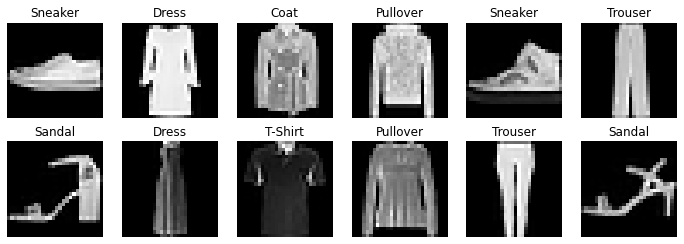

In [ ]:
#export
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

empty = cycle((None,))

def get_label(idx):
    if hasattr(idx, 'item'):
        idx = idx.item()
    return labels_map[idx]

def get_title(gt_label, pred_label):
    color = 'black'
    if gt_label is not None and pred_label is not None:
        title = f'{get_label(gt_label)} : {get_label(pred_label)}'
        color = "green" if gt_label == pred_label else "red"
    elif gt_label is not None:
        title = f'{get_label(gt_label)}'
    elif gt_label is not None:
        title = f'{get_label(pred_label)}'
    else:
        title = ''
    title = " : ".join([get_label(label) for label in (gt_label, pred_label) if label is not None])
    return title, color

def show_batch(imgs, labels=empty, preds=empty, n_samples=9, cols=3):
    if n_samples >= len(imgs):
        n_samples = len(imgs)
    rows = math.ceil(n_samples / cols)
    _, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for img, gt_label, pred_label, ax in zip(imgs, labels, preds, axs.flatten()):
        title, color = get_title(gt_label, pred_label)
        ax.set_title(title, color=color)
        ax.axis("off")
        ax.imshow(img.squeeze(), cmap="gray")


In [ ]:
batch = next(iter(train_dataloader))
show_batch(*batch, n_samples=12, cols=6)

In [ ]:
#export
class ConvBlock(nn.Module):
    n_features : int
    stride : int = 1
    activation : Callable = nn.relu
    last_activation : bool = True
    norm : Union[Callable,None] = nn.BatchNorm
    dropout : float = 0.0

    @nn.compact
    def __call__(self, x, training):
        x = nn.Conv(self.n_features, (3, 3), self.stride, 'SAME')(x)
        x = self.activation(x)
        if self.norm:
            x = self.norm(use_running_average=training)(x)
        if self.dropout > 0:
            x = nn.Dropout(self.dropout, deterministic=not training)(x)
        x = nn.Conv(self.n_features, (3, 3), 1, 'SAME')(x)
        if self.last_activation:
            x = self.activation(x)
        if self.norm:
            x = self.norm(use_running_average=training)(x)
        if self.dropout > 0:
            x = nn.Dropout(self.dropout, deterministic=not training)(x)
        return x


In [ ]:
model = ConvBlock(n_features=32)
dummy_input = np.random.randn(1, 28, 28, 1)
out, params = model.init_with_output(jax.random.PRNGKey(0), dummy_input, True)
test_eq(out.shape, (1, 28, 28, 32))
out = jax.jit(model.apply, static_argnums=2)(params, dummy_input, True)
test_eq(out.shape, (1, 28, 28, 32))
# 64 features and stride is 2, so the output shape is halved
model = ConvBlock(n_features=64, stride=2)
out, params = model.init_with_output(jax.random.PRNGKey(0), out, True)
test_eq(out.shape, (1, 14, 14, 64))
# 256 features and stride is 2 without normalization, so the output shape is halved
model = ConvBlock(n_features=256, stride=2, norm=None)
out, params = model.init_with_output(jax.random.PRNGKey(0), out, True)
test_eq(out.shape, (1, 7, 7, 256))

## Model

In [ ]:
#export
class ConvMNIST(nn.Module):
    ' comment'
    features : Sequence[int] = (32,64,256,512,1024,10)
    activation : Callable = nn.relu
    norm : Union[Callable,None] = nn.BatchNorm
    dropout : float = 0.0

    @nn.compact
    def __call__(self, x, training):
        *features, last_feature = self.features
        for n_features in features:
            x = ConvBlock(
                n_features=n_features, 
                stride=2,
                activation=self.activation, 
                norm=self.norm, 
                dropout=self.dropout)(x, training)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(last_feature)(x)
        return x

In [ ]:
model = ConvMNIST(features=[32,64,256,512,1024,10])
dummy_input = np.random.randn(1, 28, 28, 1)
out, params = model.init_with_output(jax.random.PRNGKey(0), dummy_input, True)
test_eq(out.shape, (1, 10))

In [ ]:
#export
class TrainState(train_state.TrainState):
    batch_stats : Any = None

def create_state(train_dataloader, features=None, lr=0.01, momentum=0.9):
    x, y = next(iter(train_dataloader))
    model = ConvMNIST(features) if features else ConvMNIST()
    variables = model.init(jax.random.PRNGKey(0), x, True)
    tx = sgd(lr, momentum, nesterov=True)
    return TrainState.create(
        apply_fn=model.apply, 
        params=variables['params'], 
        batch_stats=variables['batch_stats'],
        tx=tx)

def compute_metrics(*, logits, labels):
    loss = jnp.mean(softmax_cross_entropy(logits, jax.nn.one_hot(labels, 10)))
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
    return {
        'accuracy': accuracy,
        'loss': loss,
    }

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits, variables = state.apply_fn(
            {'params':params, 'batch_stats':state.batch_stats}, 
            x, True, mutable=['batch_stats'])
        loss = jnp.mean(softmax_cross_entropy(logits, jax.nn.one_hot(y, 10)))
        return loss, (logits, variables)
    x, y = batch
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, (logits, variables)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads, batch_stats=variables['batch_stats'])
    metrics = compute_metrics(logits=logits, labels=y)
    return state, metrics

def train_epoch(train_dataloader, state, log_frequency=100):
    epoch_metrics = None
    for batch in train_dataloader:
        state, metrics = train_step(state, batch)
        if epoch_metrics is None:
            epoch_metrics = metrics
        else:
            epoch_metrics = jax.tree_map(lambda x,y:jnp.append(x,y), epoch_metrics, metrics)
        if state.step % log_frequency == 0:
            print(f'\tStep {state.step}: {jax.tree_map(lambda x:jnp.mean(x).item(),epoch_metrics)}')
    return state, epoch_metrics


In [ ]:
n_epochs = 10
state = create_state(train_dataloader, features=[8,16,32,32,32,10])
for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    state, epoch_metrics = train_epoch(train_dataloader, state)
    print(f'Epoch {epoch} metrics: {jax.tree_map(lambda x:jnp.mean(x).item(),epoch_metrics)}')


True